<a href="https://colab.research.google.com/github/jagadeesh-usd/AAI530-MetroPT3-PredictiveMaintenance/blob/main/LSTM_Regression_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Long Short Term Memory Networks for IoT Prediction


In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences

## Load and prepare data

In [3]:
df = pd.read_csv('/content/household_power_consumption_cln.csv')

In [5]:
df.head()

,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime
0,0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
1,1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
2,2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
3,3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
4,4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 11 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   Date                   object 
 2   Time                   object 
 3   Global_active_power    float64
 4   Global_reactive_power  float64
 5   Voltage                float64
 6   Global_intensity       float64
 7   Sub_metering_1         float64
 8   Sub_metering_2         float64
 9   Sub_metering_3         float64
 10  Datetime               object 
dtypes: float64(7), int64(1), object(3)
memory usage: 174.2+ MB


In [7]:
df.isna().sum()

,0
Unnamed: 0,0
Date,0
Time,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0


In [8]:
if 'Datetime' in df.columns:
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df = df.sort_values('Datetime')

In [9]:
min_timestamp = df['Datetime'].min()
max_timestamp = df['Datetime'].max()

print(f"Minimum Timestamp: {min_timestamp}")
print(f"Maximum Timestamp: {max_timestamp}")

Minimum Timestamp: 2006-12-16 17:24:00
Maximum Timestamp: 2010-11-26 21:02:00


In [10]:
# create training and validation sets

# select a Random 1% Contiguous Segment
total_len = len(df)
subset_len = int(total_len * 0.01)


# pick a random starting index
np.random.seed(42) # Set seed for reproducibility
start_idx = np.random.randint(0, total_len - subset_len)

# create the 1% subset
df_subset = df.iloc[start_idx : start_idx + subset_len].copy()

# split 80/20 (Sequential Split)
# split by time: First 80% = Train, Last 20% = Validation
split_point = int(len(df_subset) * 0.8)

train_df = df_subset.iloc[:split_point]
val_df = df_subset.iloc[split_point:]

print(f"1% Subset Length: {len(df_subset)}")
print(f"Training Set: {len(train_df)} rows")
print(f"Validation Set: {len(val_df)} rows")

1% Subset Length: 20752
Training Set: 16601 rows
Validation Set: 4151 rows


In [11]:
#reset the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

In [12]:
# Reset lists to empty before the loop
seq_arrays = []
seq_labs = []

# Configuration
seq_length = 30
ph = 5
feat_cols = ['Global_active_power']

# Create list of sequence length GAP readings
# Convert the dataframe column to a numpy array for speed and easy slicing
train_values = train_df[feat_cols].values

# Loop through the data
for i in range(len(train_values) - seq_length - ph):

    # INPUT: Take the sequence from index 'i' to 'i + 30'
    input_seq = train_values[i : i + seq_length]
    seq_arrays.append(input_seq)

    # OUTPUT: Take the target value at 'i + 30 + 5' (Predictive Horizon)
    # Use [0] to extract the single scalar value from the array
    label = train_values[i + seq_length + ph][0]
    seq_labs.append(label)

# Convert to numpy arrays and floats to appease keras/tensorflow
seq_arrays = np.array(seq_arrays, dtype=object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype=object).astype(np.float32)



In [13]:
# Assertions to verify shape
assert(seq_arrays.shape == (len(train_df)-seq_length-ph, seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [14]:
print(f"seq_arrays shape: {seq_arrays.shape}")
print(f"seq_labs shape: {seq_labs.shape}")

seq_arrays shape: (16566, 30, 1)
seq_labs shape: (16566,)


**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A:
The assert statements are used to check that the input sequences (seq_arrays) and output labels (seq_labs) have the expected shapes after creating the sequences.

The first assertion verifies that the correct number of sequences was generated and that each input sequence has 30 time steps with one feature. The second assertion ensures that there is exactly one target label for each input sequence.

Assertions help catch logical errors early in the code. For example, if there were an off-by-one error in the sequence construction loop, an assertion would fail immediately, preventing the model from being trained on incorrectly shaped or misaligned data.




## Model Training

In [15]:
# path to save model
model_path = 'LSTM_model1.keras'

# build the network
nb_features = len(feat_cols)
nb_out = 1                    # predicting 1 value (GAP)

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features), # (30, 1)
         units=5,
         return_sequences=True))

model.add(Dropout(0.2))

# add second LSTM layer
model.add(LSTM(
          units=3,
          return_sequences=False))

model.add(Dropout(0.2))

model.add(Dense(units=nb_out))

model.add(Activation('linear')) # Linear activation for regression

optimizer = keras.optimizers.Adam(learning_rate = 0.01)

model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 5)          │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3)              │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252 (1008.00 B)

 Trainable params: 252 (1008.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
32/32 - 5s - 156ms/step - loss: 1.5767 - mse: 1.5767 - val_loss: 0.3623 - val_mse: 0.3623
Epoch 2/100
32/32 - 1s - 35ms/step - loss: 0.8109 - mse: 0.8109 - val_loss: 0.2764 - val_mse: 0.2764
Epoch 3/100
32/32 - 1s - 32ms/step - loss: 0.7018 - mse: 0.7018 - val_loss: 0.2659 - val_mse: 0.2659
Epoch 4/100
32/32 - 2s - 52ms/step - loss: 0.6429 - mse: 0.6429 - val_loss: 0.2581 - val_mse: 0.2581
Epoch 5/100
32/32 - 2s - 67ms/step - loss: 0.6035 - mse: 0.6035 - val_loss: 0.2526 - val_mse: 0.2526
Epoch 6/100
32/32 - 1s - 33ms/step - loss: 0.5616 - mse: 0.5616 - val_loss: 0.2505 - val_mse: 0.2505
Epoch 7/100
32/32 - 1s - 32ms/step - loss: 0.5572 - mse: 0.5572 - val_loss: 0.2566 - val_mse: 0.2566
Epoch 8/100
32/32 - 1s - 31ms/step - loss: 0.5273 - mse: 0.5273 - val_loss: 0.2525 - val_mse: 0.2525
Epoch 9/100
32/32 - 1s - 32ms/step - loss: 0.5306 - mse: 0.5306 - val_loss: 0.2455 - val_mse: 0.2455
Epoch 10/100
32/32 - 1s - 31ms/step - loss: 0.5253 - mse: 0.5253 - val_loss: 0.2538 -

The LSTM model converged smoothly, with training and validation MSE decreasing rapidly in early epochs and stabilizing thereafter. The close alignment between training and validation loss indicates good generalization with no significant overfitting. The final validation MSE (~0.24) demonstrates that the model successfully captures temporal patterns in the data.

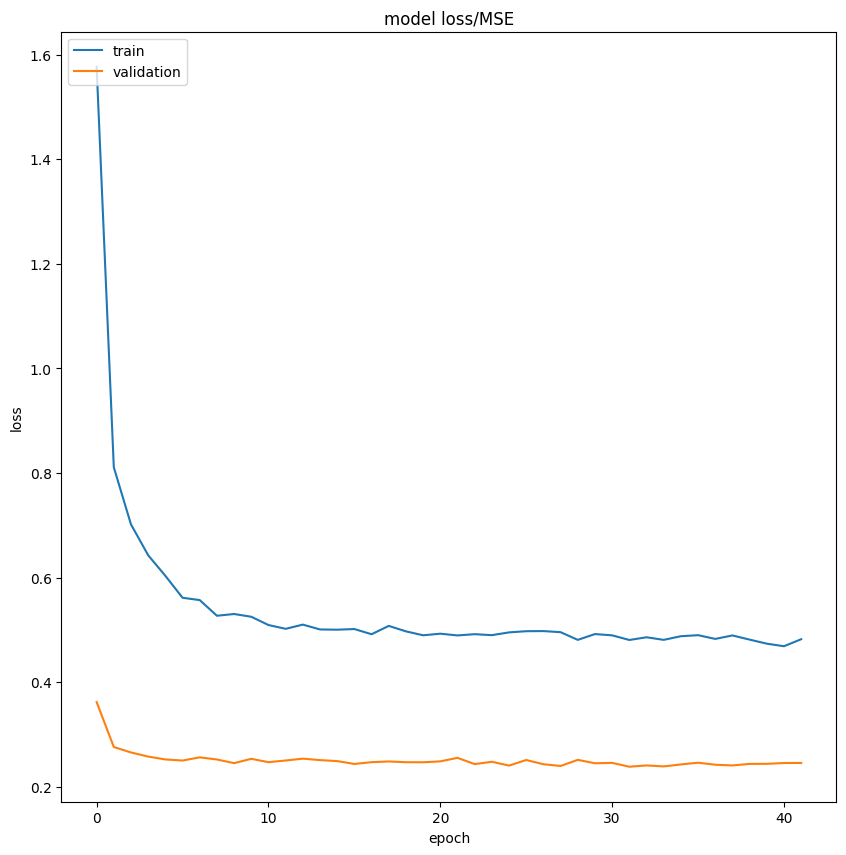

In [16]:
# summarize history for Loss/MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss/MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")


The training and validation loss decrease rapidly during the initial epochs and then stabilize, indicating effective learning of temporal patterns. The validation loss remains consistently lower and close to the training loss, suggesting good generalization and no evidence of overfitting. Early stopping prevents unnecessary training once the model performance plateaus.

## Validating our model

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A:
The pad_sequences function is used to convert variable-length sequences into fixed-length inputs by adding padding values, usually zeros. The padding argument controls whether these values are added to the beginning ('pre') or the end ('post') of a sequence. In this case, 'pre' padding makes the most sense because it keeps the most recent GAP values at the end of the sequence, which is important for time-series prediction with LSTM models.

In [17]:
val_arrays = []
val_labs = []

# Create list of GAP readings starting with a minimum of two readings
val_values = val_df['Global_active_power'].values

# Iterate through the validation data
# start at index 2
# stop at len() - ph
for i in range(2, len(val_values) - ph):

    # Logic:
    # 1. less than seq_length (30), taking all available history (e.g., 0 to 2, 0 to 3...)
    # 2. passed seq_length, takeing the most recent 30 points (Sliding Window)
    if i < seq_length:
        current_seq = val_values[0:i]
    else:
        current_seq = val_values[i - seq_length : i]

    val_arrays.append(current_seq)
    val_labs.append(val_values[i + ph])

# use the pad_sequences function to input sequences
# padding='pre' adds zeros to the START of short sequences
# dtype='float32' ensures compatibility with the model
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, padding='pre', dtype='float32', value=0.0)

# convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

In [18]:
print(f"Validation Input Shape: {val_arrays.shape}")
print(f"Validation Labels Shape: {val_labs.shape}")

Validation Input Shape: (4144, 30)
Validation Labels Shape: (4144,)


The trained LSTM model is applied to the validation data and its performance is visualized.

130/130 - 1s - 7ms/step - loss: 0.4463 - mse: 0.4463

MSE: 0.446316659450531
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


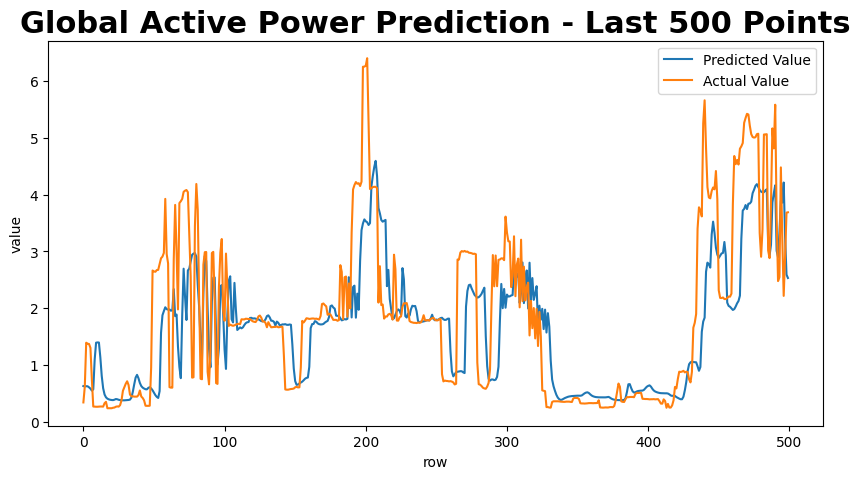

In [19]:
val_arrays = np.expand_dims(val_arrays, axis=-1)

scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

 The above plot of the last 500 validation points, the predicted Global Active Power values closely follow the overall trend and magnitude of the actual values. While some sharp peaks are slightly smoothed or under-predicted, the model successfully captures the underlying temporal patterns and regime changes in the data.

**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A: The LSTM model performs well overall, but its error is higher when evaluated on the simulated streaming validation data, with an MSE of around 0.44, compared to the lower validation loss seen during training. This is expected because many early predictions are made using padded sequences with only limited historical information. From the loss curves, the model converges quickly and the training and validation losses stay close to each other, which suggests that the model is learning effectively without overfitting. To further improve performance, we could experiment with longer input sequences, add more relevant features, or tune hyperparameters to better handle cold-start situations.


## Model Optimization

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A: To try to improve model performance, I increased the number of hidden units in the two LSTM layers from the baseline configuration to 50 and 30 units. The idea behind this change was to give the model more capacity to learn complex temporal patterns and longer-term dependencies in the Global Active Power time series. Dropout layers were kept in place to reduce the risk of overfitting as the model size increased. The optimizer and loss function were left unchanged so that any performance differences could be attributed mainly to the increased model capacity. Overall, these changes were intended to help the model better capture variability in the data, especially during periods of rapid change.

In [20]:
model_path_opt = 'LSTM_model_opt.keras'

model_opt = Sequential()

model_opt.add(keras.Input(shape=(seq_length, nb_features)))

# Layer 1: Increased to 50 units
model_opt.add(LSTM(
    units=50,
    return_sequences=True
))

model_opt.add(Dropout(0.2))

# Layer 2: Increased to 30 units
model_opt.add(LSTM(
    units=30,
    return_sequences=False
))
model_opt.add(Dropout(0.2))

model_opt.add(Dense(units=nb_out))
model_opt.add(Activation('linear'))

optimizer = keras.optimizers.Adam(learning_rate=0.01)
model_opt.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])


In [21]:
# Fit the network
history_opt = model_opt.fit(seq_arrays, seq_labs, epochs=50, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_opt, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )


Epoch 1/50
32/32 - 10s - 308ms/step - loss: 0.6658 - mse: 0.6658 - val_loss: 0.3083 - val_mse: 0.3083
Epoch 2/50
32/32 - 9s - 286ms/step - loss: 0.4489 - mse: 0.4489 - val_loss: 0.2666 - val_mse: 0.2666
Epoch 3/50
32/32 - 5s - 146ms/step - loss: 0.4329 - mse: 0.4329 - val_loss: 0.2696 - val_mse: 0.2696
Epoch 4/50
32/32 - 4s - 136ms/step - loss: 0.4350 - mse: 0.4350 - val_loss: 0.2580 - val_mse: 0.2580
Epoch 5/50
32/32 - 7s - 223ms/step - loss: 0.4262 - mse: 0.4262 - val_loss: 0.2445 - val_mse: 0.2445
Epoch 6/50
32/32 - 4s - 134ms/step - loss: 0.4237 - mse: 0.4237 - val_loss: 0.2454 - val_mse: 0.2454
Epoch 7/50
32/32 - 5s - 149ms/step - loss: 0.4224 - mse: 0.4224 - val_loss: 0.2475 - val_mse: 0.2475
Epoch 8/50
32/32 - 5s - 166ms/step - loss: 0.4163 - mse: 0.4163 - val_loss: 0.2452 - val_mse: 0.2452
Epoch 9/50
32/32 - 4s - 133ms/step - loss: 0.4158 - mse: 0.4158 - val_loss: 0.2420 - val_mse: 0.2420
Epoch 10/50
32/32 - 6s - 181ms/step - loss: 0.4084 - mse: 0.4084 - val_loss: 0.2542 - val_

Compared to the baseline model, the optimized architecture achieved a slightly lower minimum validation MSE, suggesting improved representational capacity. The divergence between continued training loss reduction and stable validation loss highlights the importance of early stopping to prevent overfitting.

Evaluating Optimized Model...
130/130 - 2s - 12ms/step - loss: 0.4108 - mse: 0.4108

Optimized Model MSE: 0.41076019406318665
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


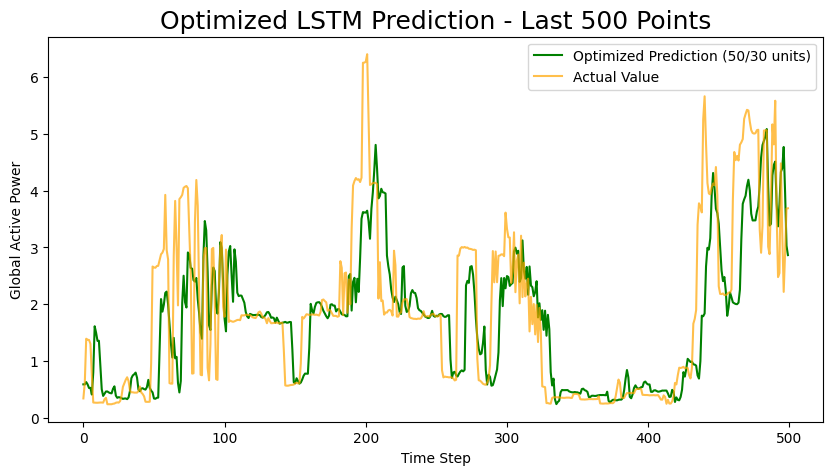

In [22]:
print("Evaluating Optimized Model...")

# Run evaluation on the same validation set
scores_test_opt = model_opt.evaluate(val_arrays, val_labs, verbose=2)
print('\nOptimized Model MSE: {}'.format(scores_test_opt[1]))

# Generate Predictions
y_pred_opt = model_opt.predict(val_arrays)

# Plot the comparison (Last 500 points)
fig_opt = plt.figure(figsize=(10, 5))
plt.plot(y_pred_opt[-500:], label='Optimized Prediction (50/30 units)', color='green')
plt.plot(val_labs[-500:], label='Actual Value', color='orange', alpha=0.7)
plt.title('Optimized LSTM Prediction - Last 500 Points', fontsize=18)
plt.ylabel('Global Active Power')
plt.xlabel('Time Step')
plt.legend()
plt.show()

**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A: When I increased the model size from 5/3 LSTM units to 50/30 units, the validation performance did improve, but only slightly. The MSE went down from 0.44 to 0.41. I think the larger model was able to capture some of the sharper spikes in power usage a bit better than the smaller model, which explains the small reduction in error.

That said, the optimized model was much slower to run (about 12 ms per step compared to 7 ms per step for the base model). Since the accuracy improvement was fairly small, the extra computational cost does not seem worth it for this problem. If I were optimizing this model for production, I would focus more on adding better input features or adjusting the sequence length rather than increasing the model size further.

**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A: Both LSTM models performed much better than the linear regression model from last week. The best linear regression model had an MSE of around 1.04, while the LSTM models achieved MSE values close to 0.44. This shows that LSTMs are better at handling the nonlinear and “spiky” nature of household power consumption data.

If I had to choose a model for an actual IoT device, I would go with the base LSTM model (5/3 units). Even though the optimized model was slightly more accurate, the difference was very small. For a battery-powered IoT device with limited resources, saving computation and power is more important than a very small improvement in accuracy. The base model provides a good balance between performance and efficiency.

### AI Disclosure
AI-assisted tools were used to help troubleshoot Python syntax issues, address Pandas deprecation warnings, and improve clarity of written explanations. All data cleaning steps, analyses, interpretations, and conclusions are my own.